# Dacon 인구 데이터 기반 소득 예측 경진대회
- 본 포스팅은 Pandas Profiling Report 활용하기, 간단한 데이터 전처리 및 EDA, LightGBM과 XGBoost로 Ensemble 모델링 등의 내용을 포함하고 있습니다.
- 코드실행은 Google Colab의 GPU, Standard RAM 환경에서 진행됐습니다.
- 작성자 : standing-o

## 0. Import Packages

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install -U pandas-profiling

In [3]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import sklearn
import pandas_profiling
import seaborn as sns
import random as rn
import os
import scipy.stats as stats

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import VotingClassifier
from sklearn import metrics

import xgboost as xgb
import lightgbm as lgb

from collections import Counter
import warnings

%matplotlib inline
warnings.filterwarnings(action='ignore')

In [4]:
print("numpy version: {}". format(np.__version__))
print("pandas version: {}". format(pd.__version__))
print("matplotlib version: {}". format(matplotlib.__version__))
print("scikit-learn version: {}". format(sklearn.__version__))
print("xgboost version: {}". format(xgb.__version__))
print("lightgbm version: {}". format(lgb.__version__))

numpy version: 1.21.6
pandas version: 1.3.5
matplotlib version: 3.2.2
scikit-learn version: 1.0.2
xgboost version: 0.90
lightgbm version: 2.2.3


In [5]:
# reproducibility
seed_num = 42   ####
np.random.seed(seed_num)
rn.seed(seed_num)
os.environ['PYTHONHASHSEED']=str(seed_num)

## 1. Load and Check Dataset

### Variable Description
|age|workclass|fnlwgt|education|education.num|marital.status|occupation|
|:---:|:---:|:---:|:---:|:---:|:---:|:---:|
|나이|일 유형|CPS(Current Population Survey) 가중치|교육수준|교육수준 번호|결혼 상태|직업|

|relationship|race|sex|capital.gain|capital.loss|hours.per.week|native.country|
|:---:|:---:|:---:|:---:|:---:|:---:|:---:|
|가족관계|인종|성별|자본 이익|자본 손실|주당 근무시간|본 국적|

In [6]:
train = pd.read_csv('/content/drive/MyDrive/Forecasting_income/dataset/train.csv')
test = pd.read_csv('/content/drive/MyDrive/Forecasting_income/dataset/test.csv')

train.columns = train.columns.str.replace('.','_')
test.columns = test.columns.str.replace('.','_')

train.head()

id  age workclass  fnlwgt     education  education_num      marital_status  \
0   0   32   Private  309513    Assoc-acdm             12  Married-civ-spouse   
1   1   33   Private  205469  Some-college             10  Married-civ-spouse   
2   2   46   Private  149949  Some-college             10  Married-civ-spouse   
3   3   23   Private  193090     Bachelors             13       Never-married   
4   4   55   Private   60193       HS-grad              9            Divorced   

        occupation   relationship   race     sex  capital_gain  capital_loss  \
0     Craft-repair        Husband  White    Male             0             0   
1  Exec-managerial        Husband  White    Male             0             0   
2     Craft-repair        Husband  White    Male             0             0   
3     Adm-clerical      Own-child  White  Female             0             0   
4     Adm-clerical  Not-in-family  White  Female             0             0   

   hours_per_week native_country  target  
0              40  United-States       0  
1              40  United-States       1  
2              40  United-States       0  
3              30  United-States       0  
4              40  United-States       0

In [ ]:
pr=train.profile_report()
pr.to_file('/content/drive/MyDrive/Forecasting_income/pr_report.html')

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
pr

### **Pandas profiling report**의 Alert 활용하기
#### **High Correlation**
1. `relationship` - `sex` 
2. `age` - `marital.status`
3. `workclass` - `occupation`
4. `education` - `education.num`
5. `relationship` -  `marital.status`
6. `race` - `native.country`
7. `sex` - `occupation`
8. `target` - `relationship`

#### **Data Type**
- Numeric (7) : `id`, `age`, `fnlwgt`, `education.num`, `capital.gain`, `capital.loss`, `hours.per.week`
- Categorical (9) : `workclass`, `education`, `marital.status`, `occupation`, `relationship`, `race`, `sex`, `native.country`, `target`
  
#### **etc**
- `workclass`와 `occupation`이 같은 비율 (10.5%)의 missing value를 가지므로 확인해 볼 필요가 있습니다.  
- 또한, `native.country`는 583(3.3%) missing value를 가지므로 행을 삭제해주겠습니다.
- `capital.gain`, `capital.loss`가 high skewness를 가집니다. outlier를 확인하고 필요시 transformation을 진행하겠습니다.


In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17480 entries, 0 to 17479
Data columns (total 16 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   id              17480 non-null  int64 
 1   age             17480 non-null  int64 
 2   workclass       15644 non-null  object
 3   fnlwgt          17480 non-null  int64 
 4   education       17480 non-null  object
 5   education_num   17480 non-null  int64 
 6   marital_status  17480 non-null  object
 7   occupation      15637 non-null  object
 8   relationship    17480 non-null  object
 9   race            17480 non-null  object
 10  sex             17480 non-null  object
 11  capital_gain    17480 non-null  int64 
 12  capital_loss    17480 non-null  int64 
 13  hours_per_week  17480 non-null  int64 
 14  native_country  16897 non-null  object
 15  target          17480 non-null  int64 
dtypes: int64(8), object(8)
memory usage: 2.1+ MB


In [8]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15081 entries, 0 to 15080
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   id              15081 non-null  int64 
 1   age             15081 non-null  int64 
 2   workclass       15081 non-null  object
 3   fnlwgt          15081 non-null  int64 
 4   education       15081 non-null  object
 5   education_num   15081 non-null  int64 
 6   marital_status  15081 non-null  object
 7   occupation      15081 non-null  object
 8   relationship    15081 non-null  object
 9   race            15081 non-null  object
 10  sex             15081 non-null  object
 11  capital_gain    15081 non-null  int64 
 12  capital_loss    15081 non-null  int64 
 13  hours_per_week  15081 non-null  int64 
 14  native_country  15081 non-null  object
dtypes: int64(7), object(8)
memory usage: 1.7+ MB


## 2. Data Preprocessing

### (1) Missing Value

In [9]:
train.columns[train.isnull().any()]

Index(['workclass', 'occupation', 'native_country'], dtype='object')

In [10]:
train[train["workclass"].isnull()]

id  age workclass  fnlwgt     education  education_num  \
15081  15081   90       NaN   77053       HS-grad              9   
15082  15082   66       NaN  186061  Some-college             10   
15084  15084   51       NaN  172175     Doctorate             16   
15086  15086   61       NaN  135285       HS-grad              9   
15087  15087   71       NaN  100820       HS-grad              9   
...      ...  ...       ...     ...           ...            ...   
17475  17475   35       NaN  320084     Bachelors             13   
17476  17476   30       NaN   33811     Bachelors             13   
17477  17477   71       NaN  287372     Doctorate             16   
17478  17478   41       NaN  202822       HS-grad              9   
17479  17479   72       NaN  129912       HS-grad              9   

           marital_status occupation   relationship                race  \
15081             Widowed        NaN  Not-in-family               White   
15082             Widowed        NaN      Unmarried               Black   
15084       Never-married        NaN  Not-in-family               White   
15086  Married-civ-spouse        NaN        Husband               White   
15087  Married-civ-spouse        NaN        Husband               White   
...                   ...        ...            ...                 ...   
17475  Married-civ-spouse        NaN           Wife               White   
17476       Never-married        NaN  Not-in-family  Asian-Pac-Islander   
17477  Married-civ-spouse        NaN        Husband               White   
17478           Separated        NaN  Not-in-family               Black   
17479  Married-civ-spouse        NaN        Husband               White   

          sex  capital_gain  capital_loss  hours_per_week native_country  \
15081  Female             0          4356              40  United-States   
15082  Female             0          4356              40  United-States   
15084    Male             0          2824              40  United-States   
15086    Male             0          2603              32  United-States   
15087    Male             0          2489              15  United-States   
...       ...           ...           ...             ...            ...   
17475  Female             0             0              55  United-States   
17476  Female             0             0              99  United-States   
17477    Male             0             0              10  United-States   
17478  Female             0             0              32  United-States   
17479    Male             0             0              25  United-States   

       target  
15081       0  
15082       0  
15084       1  
15086       0  
15087       0  
...       ...  
17475       1  
17476       0  
17477       1  
17478       0  
17479       0  

[1836 rows x 16 columns]

In [48]:
train['workclass'].unique()

array(['Private', 'State-gov', 'Local-gov', 'Self-emp-not-inc',
       'Self-emp-inc', 'Federal-gov', 'Without-pay', nan, 'Never-worked'],
      dtype=object)

- `workclass`, `occupation` 컬럼의 결측치를 포함한 행은 삭제합니다.
- 두 컬럼이 동시에 결측치를 갖는 경우가 대부분이었기에 `workclass`의 결측치만 'Never-worked'와 같은 이미 존재하는 특성으로 채우는것은 의미가 없습니다.
- `workclass`와 `occupation`에 새 feature을 생성하여 넣는 방법도 시도했지만, one-hot encoding을 해서 생기는 test 데이터와의 컬럼 차이 때문에 다른 방법을 고려해볼 필요가 있다고 생각합니다. 😔😔

In [11]:
print(sum(train['workclass'].isna()))
print(sum(train['occupation'].isna()))

fill_na = train['workclass'].isna()

1836
1843


In [15]:
df_train = train.dropna()  

print(sum(df_train['workclass'].isna()))
print(sum(df_train['occupation'].isna()))
print(sum(df_train['native_country'].isna()))

0
0
0


In [16]:
df_train

id  age     workclass  fnlwgt     education  education_num  \
0          0   32       Private  309513    Assoc-acdm             12   
1          1   33       Private  205469  Some-college             10   
2          2   46       Private  149949  Some-college             10   
3          3   23       Private  193090     Bachelors             13   
4          4   55       Private   60193       HS-grad              9   
...      ...  ...           ...     ...           ...            ...   
15076  15076   35       Private  337286       Masters             14   
15077  15077   36       Private  182074  Some-college             10   
15078  15078   50  Self-emp-inc  175070   Prof-school             15   
15079  15079   39       Private  202937  Some-college             10   
15080  15080   33       Private   96245    Assoc-acdm             12   

           marital_status       occupation   relationship                race  \
0      Married-civ-spouse     Craft-repair        Husband               White   
1      Married-civ-spouse  Exec-managerial        Husband               White   
2      Married-civ-spouse     Craft-repair        Husband               White   
3           Never-married     Adm-clerical      Own-child               White   
4                Divorced     Adm-clerical  Not-in-family               White   
...                   ...              ...            ...                 ...   
15076       Never-married  Exec-managerial  Not-in-family  Asian-Pac-Islander   
15077            Divorced     Adm-clerical  Not-in-family               White   
15078  Married-civ-spouse   Prof-specialty        Husband               White   
15079            Divorced     Tech-support  Not-in-family               White   
15080  Married-civ-spouse   Prof-specialty        Husband               White   

          sex  capital_gain  capital_loss  hours_per_week native_country  \
0        Male             0             0              40  United-States   
1        Male             0             0              40  United-States   
2        Male             0             0              40  United-States   
3      Female             0             0              30  United-States   
4      Female             0             0              40  United-States   
...       ...           ...           ...             ...            ...   
15076    Male             0             0              40  United-States   
15077    Male             0             0              45  United-States   
15078    Male             0             0              45  United-States   
15079  Female             0             0              40         Poland   
15080    Male             0             0              50  United-States   

       target  
0           0  
1           1  
2           0  
3           0  
4           0  
...       ...  
15076       0  
15077       0  
15078       1  
15079       0  
15080       0  

[15081 rows x 16 columns]

### (2) Outlier

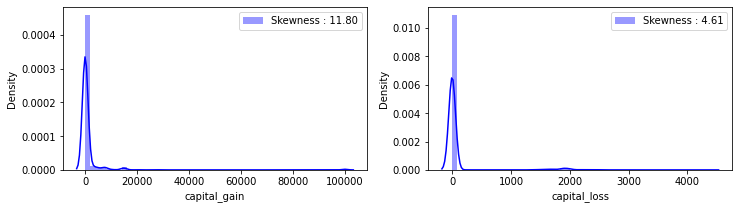

In [17]:
fig, ax = plt.subplots(1, 2, figsize=(12,3))
g = sns.distplot(df_train['capital_gain'], color='b', label='Skewness : {:.2f}'.format(df_train['capital_gain'].skew()), ax=ax[0])
g = g.legend(loc='best')

g = sns.distplot(df_train['capital_loss'], color='b', label='Skewness : {:.2f}'.format(df_train['capital_loss'].skew()), ax=ax[1])
g = g.legend(loc='best')
plt.show()

In [18]:
numeric_fts = ['age', 'fnlwgt', 'education_num', 'capital_gain', 'capital_loss', 'hours_per_week']

outlier_ind = []
for i in numeric_fts:
  Q1 = np.percentile(df_train[i],25)
  Q3 = np.percentile(df_train[i],75)
  IQR = Q3-Q1
  outlier_list = df_train[(df_train[i] < Q1 - IQR * 1.5) | (df_train[i] > Q3 + IQR * 1.5)].index
  outlier_ind.extend(outlier_list)

In [19]:
outlier_ind = Counter(outlier_ind)
multi_outliers = list(k for k,j in outlier_ind.items() if j > 2)

In [20]:
# Drop outliers
train_df = df_train.drop(multi_outliers, axis = 0).reset_index(drop = True)
train_df

id  age     workclass  fnlwgt     education  education_num  \
0          0   32       Private  309513    Assoc-acdm             12   
1          1   33       Private  205469  Some-college             10   
2          2   46       Private  149949  Some-college             10   
3          3   23       Private  193090     Bachelors             13   
4          4   55       Private   60193       HS-grad              9   
...      ...  ...           ...     ...           ...            ...   
15043  15076   35       Private  337286       Masters             14   
15044  15077   36       Private  182074  Some-college             10   
15045  15078   50  Self-emp-inc  175070   Prof-school             15   
15046  15079   39       Private  202937  Some-college             10   
15047  15080   33       Private   96245    Assoc-acdm             12   

           marital_status       occupation   relationship                race  \
0      Married-civ-spouse     Craft-repair        Husband               White   
1      Married-civ-spouse  Exec-managerial        Husband               White   
2      Married-civ-spouse     Craft-repair        Husband               White   
3           Never-married     Adm-clerical      Own-child               White   
4                Divorced     Adm-clerical  Not-in-family               White   
...                   ...              ...            ...                 ...   
15043       Never-married  Exec-managerial  Not-in-family  Asian-Pac-Islander   
15044            Divorced     Adm-clerical  Not-in-family               White   
15045  Married-civ-spouse   Prof-specialty        Husband               White   
15046            Divorced     Tech-support  Not-in-family               White   
15047  Married-civ-spouse   Prof-specialty        Husband               White   

          sex  capital_gain  capital_loss  hours_per_week native_country  \
0        Male             0             0              40  United-States   
1        Male             0             0              40  United-States   
2        Male             0             0              40  United-States   
3      Female             0             0              30  United-States   
4      Female             0             0              40  United-States   
...       ...           ...           ...             ...            ...   
15043    Male             0             0              40  United-States   
15044    Male             0             0              45  United-States   
15045    Male             0             0              45  United-States   
15046  Female             0             0              40         Poland   
15047    Male             0             0              50  United-States   

       target  
0           0  
1           1  
2           0  
3           0  
4           0  
...       ...  
15043       0  
15044       0  
15045       1  
15046       0  
15047       0  

[15048 rows x 16 columns]

In [21]:
print(train_df['capital_gain'].skew(), train_df['capital_loss'].skew())

12.004940559585881 4.607122286739042


- Outlier들을 제거했음에도 두 변수는 여전히 high skewness를 가지고 있으므로 log transformation을 진행해보고자 합니다.

In [22]:
# log transformation
train_df['capital_gain'] = train_df['capital_gain'].map(lambda i: np.log(i) if i > 0 else 0)
test['capital_gain'] = test['capital_gain'].map(lambda i: np.log(i) if i > 0 else 0)

train_df['capital_loss'] = train_df['capital_loss'].map(lambda i: np.log(i) if i > 0 else 0)
test['capital_loss'] = test['capital_loss'].map(lambda i: np.log(i) if i > 0 else 0)

In [23]:
print(train_df['capital_gain'].skew(), train_df['capital_loss'].skew())

3.0945787119106676 4.390015583095806


## 3. Feature Engineering

#### (1) Correlation
- Categorical 데이터를 라벨인코더를 통해 수치형으로 변환한 후 상관관계를 확인합니다.
- Categorical : `workclass`, `education`, `marital.status`, `occupation`, `relationship`, `race`, `sex`, `native.country`

In [24]:
la_train = train_df.copy()

cat_fts = ['workclass', 'education', 'marital_status', 'occupation', 'relationship', 'race', 'sex', 'native_country']
for i in range(len(cat_fts)):
  encoder = LabelEncoder()
  la_train[cat_fts[i]] = encoder.fit_transform(la_train[cat_fts[i]])

In [25]:
la_train.head()

id  age  workclass  fnlwgt  education  education_num  marital_status  \
0   0   32          2  309513          7             12               2   
1   1   33          2  205469         15             10               2   
2   2   46          2  149949         15             10               2   
3   3   23          2  193090          9             13               4   
4   4   55          2   60193         11              9               0   

   occupation  relationship  race  sex  capital_gain  capital_loss  \
0           2             0     4    1           0.0           0.0   
1           3             0     4    1           0.0           0.0   
2           2             0     4    1           0.0           0.0   
3           0             3     4    0           0.0           0.0   
4           0             1     4    0           0.0           0.0   

   hours_per_week  native_country  target  
0              40              38       0  
1              40              38       1  
2              40              38       0  
3              30              38       0  
4              40              38       0

- 앞서 수행한 pandas profiling report의 alert를 참고하여 상관계수를 계산했습니다.
- 꽤 유의미한 상관관계를 가지고 있다고 생각되는것은 `relationship`-`sex`, `occupation`-`workclass`, `education`-`education.num` 입니다.

In [26]:
# Pearson
la_train[['age','marital_status', 'relationship', 'sex', 'occupation', 'workclass']].corr()

age  marital_status  relationship       sex  occupation  \
age             1.000000       -0.271955     -0.240331  0.087515   -0.007994   
marital_status -0.271955        1.000000      0.180281 -0.124481    0.023856   
relationship   -0.240331        0.180281      1.000000 -0.590077   -0.052109   
sex             0.087515       -0.124481     -0.590077  1.000000    0.061443   
occupation     -0.007994        0.023856     -0.052109  0.061443    1.000000   
workclass       0.081100       -0.044000     -0.070512  0.078764    0.010194   

                workclass  
age              0.081100  
marital_status  -0.044000  
relationship    -0.070512  
sex              0.078764  
occupation       0.010194  
workclass        1.000000

In [27]:
la_train[['education', 'education_num', 'race', 'native_country']].corr()

education  education_num      race  native_country
education        1.000000       0.348614  0.011236        0.079063
education_num    0.348614       1.000000  0.034686        0.097485
race             0.011236       0.034686  1.000000        0.126654
native_country   0.079063       0.097485  0.126654        1.000000

- Categorical 인 두 변수의 경우는 Cramer's V 공식을 활용하여 상관관계를 확인했습니다.

In [28]:
stat = stats.chi2_contingency(la_train[['race', 'native_country']].values, correction=False)[0]
obs = np.sum(la_train[['race', 'native_country']].values) 
mini = min(la_train[['race', 'native_country']].values.shape)-1 

# Cramer's V 
V = np.sqrt((stat/(obs*mini)))
print(V)

0.11306993147326666


#### (2) String to numerical
- Categorical 데이터를 모델에 넣기 위해서는 수치화 시킬 필요가 있습니다. LabelEncoder는 불필요한 상관관계를 만들 가능성이 있기에 OnehotEncoder를 사용했습니다.
- Categorical : `workclass`, `education`, `marital.status`, `occupation`, `relationship`, `race`, `sex`, `native.country`

In [29]:
train_dataset = train_df.copy()
test_dataset = test.copy()

- get_dummies를 사용하여 one-hot encoding을 진행했습니다.

In [30]:
train_dataset = pd.get_dummies(train_dataset)
test_dataset = pd.get_dummies(test_dataset)

print(train_dataset.columns)
print(test_dataset.columns)

Index(['id', 'age', 'fnlwgt', 'education_num', 'capital_gain', 'capital_loss',
       'hours_per_week', 'target', 'workclass_Federal-gov',
       'workclass_Local-gov',
       ...
       'native_country_Portugal', 'native_country_Puerto-Rico',
       'native_country_Scotland', 'native_country_South',
       'native_country_Taiwan', 'native_country_Thailand',
       'native_country_Trinadad&Tobago', 'native_country_United-States',
       'native_country_Vietnam', 'native_country_Yugoslavia'],
      dtype='object', length=106)
Index(['id', 'age', 'fnlwgt', 'education_num', 'capital_gain', 'capital_loss',
       'hours_per_week', 'workclass_Federal-gov', 'workclass_Local-gov',
       'workclass_Private',
       ...
       'native_country_Portugal', 'native_country_Puerto-Rico',
       'native_country_Scotland', 'native_country_South',
       'native_country_Taiwan', 'native_country_Thailand',
       'native_country_Trinadad&Tobago', 'native_country_United-States',
       'native_country_V

- train과 test의 열길이를 맞춰주는 작업을 합니다.

In [31]:
test_col = []
add_test = []

for i in test_dataset.columns:
    test_col.append(i)
for j in train_dataset.columns:
    if j not in test_col:
        add_test.append(j)
add_test.remove('target')

- test 데이터의 `native.country` 컬럼에는 'Holand-Netherlands' 특성이 없는걸까요?

In [33]:
print(add_test)

['native_country_Holand-Netherlands']


In [34]:
for d in add_test:
    test_dataset[d] = 0

In [35]:
print(train_dataset.columns)
print(test_dataset.columns)

Index(['id', 'age', 'fnlwgt', 'education_num', 'capital_gain', 'capital_loss',
       'hours_per_week', 'target', 'workclass_Federal-gov',
       'workclass_Local-gov',
       ...
       'native_country_Portugal', 'native_country_Puerto-Rico',
       'native_country_Scotland', 'native_country_South',
       'native_country_Taiwan', 'native_country_Thailand',
       'native_country_Trinadad&Tobago', 'native_country_United-States',
       'native_country_Vietnam', 'native_country_Yugoslavia'],
      dtype='object', length=106)
Index(['id', 'age', 'fnlwgt', 'education_num', 'capital_gain', 'capital_loss',
       'hours_per_week', 'workclass_Federal-gov', 'workclass_Local-gov',
       'workclass_Private',
       ...
       'native_country_Puerto-Rico', 'native_country_Scotland',
       'native_country_South', 'native_country_Taiwan',
       'native_country_Thailand', 'native_country_Trinadad&Tobago',
       'native_country_United-States', 'native_country_Vietnam',
       'native_country_Yu

- Train의 target column을 제외하고 보면 열길이가 잘 맞춰진것을 확인할 수 있습니다.

## 4. Modeling
- 먼저, train과 validation 데이터를 train_test_split 함수를 사용하여 나눠줍니다.

In [36]:
test_size =0.15

train_data, val_data = train_test_split(train_dataset, test_size = test_size, random_state = seed_num)

drop_col = ['target', 'id']

train_x = train_data.drop(drop_col, axis = 1)
train_y = pd.DataFrame(train_data['target'])

val_x = val_data.drop(drop_col, axis = 1)
val_y = pd.DataFrame(val_data['target'])

In [37]:
print(train_x.shape, train_y.shape)
print(val_x.shape, val_y.shape)

(12790, 104) (12790, 1)
(2258, 104) (2258, 1)


- LGBM과 XGboost를 Soft Voting하여 간단한 ensemble 모델을 제작했습니다.
- Soft Voting은 LGBM, XGboost 모델의 예측 확률을 평균하여 최종 class를 결정합니다.

In [38]:
LGBClassifier = lgb.LGBMClassifier(random_state = seed_num)

In [ ]:
lgbm = LGBClassifier.fit(train_x.values,
                       train_y.values.ravel(),
                       eval_set = [(train_x.values, train_y), (val_x.values, val_y)], 
                       eval_metric ='auc', early_stopping_rounds = 1000,
                       verbose = True)

In [40]:
XGBClassifier = xgb.XGBClassifier(max_depth = 6, learning_rate = 0.01, n_estimators = 10000, random_state = seed_num)

In [ ]:
xgb = XGBClassifier.fit(train_x.values,
                       train_y.values.ravel(),
                       eval_set = [(train_x.values, train_y), (val_x.values, val_y)], 
                       eval_metric = 'auc', early_stopping_rounds = 1000,
                       verbose = True)

In [42]:
voting = VotingClassifier(estimators=[('xgb', xgb),('lgbm', lgbm)], voting='soft')
vot = voting.fit(train_x.values, train_y.values)

## 5. Evaluation & Submission

In [51]:
l_val_y_pred = lgbm.predict(val_x.values)
x_val_y_pred = xgb.predict(val_x.values)
v_val_y_pred = vot.predict(val_x.values)

In [52]:
print(metrics.accuracy_score(l_val_y_pred, val_y))
print(metrics.accuracy_score(x_val_y_pred, val_y))
print(metrics.accuracy_score(v_val_y_pred, val_y))

0.8702391496899912
0.8680248007085917
0.8596102745792737


In [53]:
print(metrics.classification_report(v_val_y_pred, val_y))

              precision    recall  f1-score   support

           0       0.93      0.89      0.91      1800
           1       0.63      0.72      0.68       458

    accuracy                           0.86      2258
   macro avg       0.78      0.81      0.79      2258
weighted avg       0.87      0.86      0.86      2258



In [54]:
val_xgb = pd.Series(l_val_y_pred, name="XGB")
val_lgbm = pd.Series(x_val_y_pred, name="LGBM")

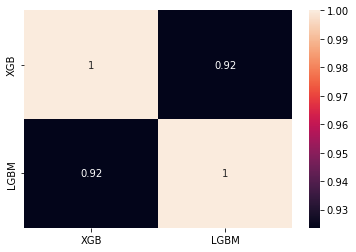

In [55]:
ensemble_results = pd.concat([val_xgb,val_lgbm],axis=1)
sns.heatmap(ensemble_results.corr(), annot=True)
plt.show()

- Soft Voting을 진행했음에도 성능이 향상되지 않았습니다. 
- 두 모델의 예측은 높은 상관관계를 가지고 있었기에 앙상블 이전보다 성능이 향상되지 않았다고 해석할 수 있습니다.  
(조금 더 공부가 필요할것 같습니다 😂😂)

### 감사합니다 :)
도움이 됐길 바랍니다👍👍